In [1]:
!git clone https://github.com/skaldek/ImageNet-Datasets-Downloader DOWNLOADER
!mkdir DATA
!mkdir PRECALCULATED
!mkdir CHECKPOINTS
# vehicle armored car fishing boat airplane bumper car
!python DOWNLOADER/downloader.py \
    -data_root DATA \
    -use_class_list True \
    -class_list n06255081 n02739889 n03351262 n02691156 n02918964 \
    -images_per_class 10000

fatal: destination path 'DOWNLOADER' already exists and is not an empty directory.
A subdirectory or file DATA already exists.


^C


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
from torch.utils.data import DataLoader

import euclidean_model
import dataset
import model

In [2]:
def show(images, size=(10, 10), grayscale=False):
    plt.figure()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

    rows = int(np.ceil(len(images) / 3.0))

    if grayscale:
        m = images
    else:
        m = model.Model.lab_to_rgb(images)
    for i, image in enumerate(m):
        plt.subplot(rows, 3, i + 1)

        if grayscale:
            image = image[0, :, :]
            plt.imshow(image, cmap="gray")
        else:
            plt.imshow(image)
        plt.axis("off")
    plt.show()

In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

1
NVIDIA GeForce GTX 1060 6GB


In [4]:
def H_inv(y_batch, q_to_ab, neighbours):
    # values between 0 and 100 and -110 to +110
    b, c, h, w = y_batch.shape
    y_batch_permuted = y_batch.permute(1, 0, 2, 3).reshape(2, -1)
    cdist = torch.cdist(q_to_ab, y_batch_permuted.t())
    nns = (cdist.sort(dim=0)[1])[:neighbours, :]  # 5, 64*64*8
    nn_gauss = y_batch_permuted.new_zeros(neighbours, b * h * w)

    sigma = 5
    norm = 1 / (2 * np.pi * sigma)
    for i in range(neighbours):
        nn_gauss[i, :] = norm * torch.exp(
            -torch.sum((q_to_ab[nns[i, :], :].t() - y_batch_permuted) ** 2, dim=0) / (2 * sigma ** 2))

    # normalize
    nn_gauss /= nn_gauss.sum(dim=0, keepdim=True)
    bins = 313
    q = y_batch.new_zeros(bins, b * h * w)
    q[nns, torch.arange(b * h * w).repeat(neighbours, 1)] = nn_gauss
    Z = q.reshape(bins, b, h, w).permute(1, 0, 2, 3)
    return Z


def H(Z_batch, T, q_to_ab):
    if T == 0:
        mode = Z_batch.max(dim=1, keepdim=True)[1]

        _, _, h, w = mode.shape
        ab = torch.stack([
            q_to_ab.index_select(
                0, mode_.flatten()
            ).reshape(h, w, 2).permute(2, 0, 1)

            for mode_ in mode
        ])
    else:
        Z_batch = torch.exp(Z_batch / T)
        Z_batch /= Z_batch.sum(dim=1, keepdim=True)

        a = torch.tensordot(Z_batch, q_to_ab[:, 0], dims=((1,), (0,))).unsqueeze(1)
        b = torch.tensordot(Z_batch, q_to_ab[:, 1], dims=((1,), (0,))).unsqueeze(1)

        ab = torch.cat((a, b), dim=1)
    return ab

In [5]:
def compute_p(dataloader, Q_shape, q_to_ab):
    p = torch.zeros(Q_shape)
    for idx, batch in enumerate(dataloader):
        print("idx: ", idx)

        ab = batch[:, 1:, :, :]
        Z_batch = H_inv(ab, q_to_ab, 1)

        # Z_batch: (8, 313, 64, 64)
        b, Q, H, W, = Z_batch.shape
        Z_batch = torch.permute(Z_batch, (0, 2, 3, 1))  # b, H, W, Q,

        # (b*H*W, Q)
        Z_batch_flat = Z_batch.reshape((b * H * W, Q_shape))
        p_batch = torch.sum(Z_batch_flat, dim=0)
        p += p_batch
        p /= p.sum()
    return p

def smooth(p):
    p = gaussian_filter(p, sigma=5)
    p /= p.sum()
    return p

def compute_w(p, lamb):
    Q = (p > 0).sum()
    w = 1 / (((1 - lamb) * p) + lamb / Q)
    return w / sum(p * w)


def v(Z_batch, weights_to_rebalance):
    w = weights_to_rebalance
    b, c, H, W = Z_batch.shape
    Z_batch_flattened = torch.reshape(Z_batch, (b, c, H * W))
    batch_idxs = torch.arange(b)
    # shape: (8, 64*64)
    idxs = torch.argmax(Z_batch_flattened[batch_idxs, :, :], dim=1)
    return w[idxs].reshape(b, 1, H, W)

In [6]:
split = lambda d: torch.utils.data.random_split(d, [0.8, 0.1, 0.1], torch.Generator().manual_seed(0))

batch_size = 32
num_workers = 4

croppped_data = dataset.Dataset(176, True)
full_data = dataset.Dataset(176, False)

print(len(full_data))

train_cropped, val_cropped, test_cropped = split(croppped_data)
train_full, val_full, test_full = split(full_data)

train_cropped = DataLoader(train_cropped, batch_size=batch_size, num_workers=num_workers, shuffle=True,
                   collate_fn=dataset.collate_fn)
test_cropped = DataLoader(test_cropped, batch_size=batch_size, num_workers=num_workers, shuffle=True,
                  collate_fn=dataset.collate_fn)
val_cropped = DataLoader(val_cropped, batch_size=batch_size, num_workers=num_workers, shuffle=True,
                 collate_fn=dataset.collate_fn)
train_full = DataLoader(train_full, batch_size=batch_size, num_workers=num_workers, shuffle=True,
                        collate_fn=dataset.collate_fn)
test_full = DataLoader(test_full, batch_size=batch_size, num_workers=num_workers, shuffle=True,
                       collate_fn=dataset.collate_fn)
val_full = DataLoader(val_full, batch_size=batch_size, num_workers=num_workers, shuffle=True,
                      collate_fn=dataset.collate_fn)

print("train: ", len(train_full) * batch_size)
print("test: ", len(test_full) * batch_size)
print("val: ", len(val_full) * batch_size)

2186
train:  1760
test:  224
val:  224


In [7]:
images = next(iter(train_full))

In [8]:
q_to_ab = torch.from_numpy(np.load("PRECALCULATED/ab-gamut.npy")).float().to(device)
q_length = q_to_ab.shape[0]

must_compute_p = False
if must_compute_p:
    new = compute_p(train_full, q_length, q_to_ab.cpu())
    torch.save(new, "PRECALCULATED/p.pt")

p = torch.load("PRECALCULATED/p.pt").to(device)
p_smooth = torch.tensor(smooth(p.cpu())).to(device)
p_prior = torch.from_numpy(np.load("PRECALCULATED/p-prior.npy")).to(device)
p_prior_smooth = torch.tensor(smooth(p_prior.cpu())).to(device)

weights = compute_w(p, lamb=0.5)

In [9]:
# plt.plot(weights.cpu(), label="p")
# w_other = compute_w(p_prior, lamb=0.5)
# plt.plot(w_other.cpu(), label="p_prior")
# # plt.plot(p_prior_smooth.cpu())
# plt.legend()

In [12]:
import importlib

importlib.reload(model)
importlib.reload(euclidean_model)

h_inv = lambda ab: H_inv(ab, q_to_ab, 5)
h = lambda z: H(z, 0.38, q_to_ab)

v_prepared = lambda z: v(z, weights)
cross_entropy_rebalanced = lambda y_pred, y: model.Model.cross_entropy_rebalanced(y_pred, y, v_prepared)
cross_entropy = model.Model.cross_entropy

# m = model.Model("balanced_ours", q_length, h, h_inv, cross_entropy_rebalanced).to(device)
# m.train_model(train_cropped, val_cropped, 10000000000000000000000000000)

m = euclidean_model.EuclideanModel().to(device)
m.train_model(train_cropped, val_cropped, 100)


# m.test(train_cropped)
# m.test(train_full)
#
m.test(test_cropped)
m.test(test_full)

Epoch: 1, Train loss: 0.01989947198466821, Validation loss: 0.017657303251326084, Time: 0:01:16.258955
Epoch: 2, Train loss: 0.019161751002750613, Validation loss: 0.01837627775967121, Time: 0:01:23.939495
Epoch: 3, Train loss: 0.019129534539851275, Validation loss: 0.018143185414373875, Time: 0:01:24.468185
Epoch: 4, Train loss: 0.01900224353779446, Validation loss: 0.01832188426383904, Time: 0:01:21.829484
Epoch: 5, Train loss: 0.01891010586511005, Validation loss: 0.017928980823074068, Time: 0:01:20.912954
Epoch: 6, Train loss: 0.01907120006666942, Validation loss: 0.017364827383841788, Time: 0:01:23.326676
Epoch: 7, Train loss: 0.01871435684575276, Validation loss: 0.018363048721637045, Time: 0:01:22.612635
Epoch: 8, Train loss: 0.018733057549053973, Validation loss: 0.01714631768741778, Time: 0:01:23.197220
Epoch: 9, Train loss: 0.018681100789796224, Validation loss: 0.018167021551302502, Time: 0:01:21.683488
Epoch: 10, Train loss: 0.018325953321023422, Validation loss: 0.01880427

D:\Users\wgaud\Downloads\ImageColoring\model.py:210: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim += SSIM(pred_rgb, rgb, datarange=1, channel_axis=2, multichannel=True)


RMSE AB: 12.950729704051584
RMSE: 0.07774079348351866
PSNR: 23.56791218154787
SSIM: 0.925412098250858
RMSE AB: 13.478853183869317
RMSE: 0.08033958960125401
PSNR: 23.286839636779536
SSIM: 0.922696788820713


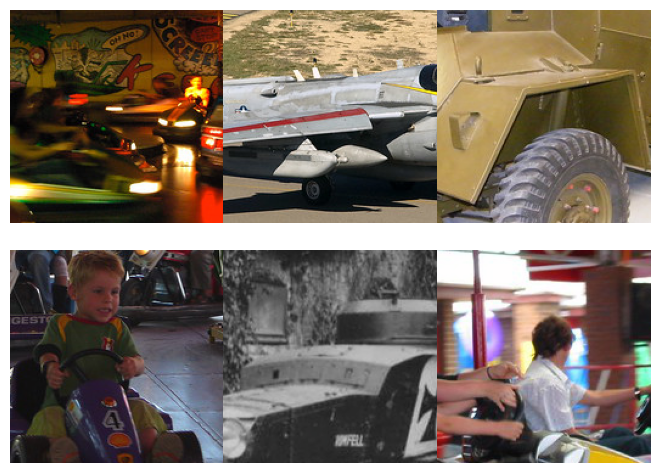

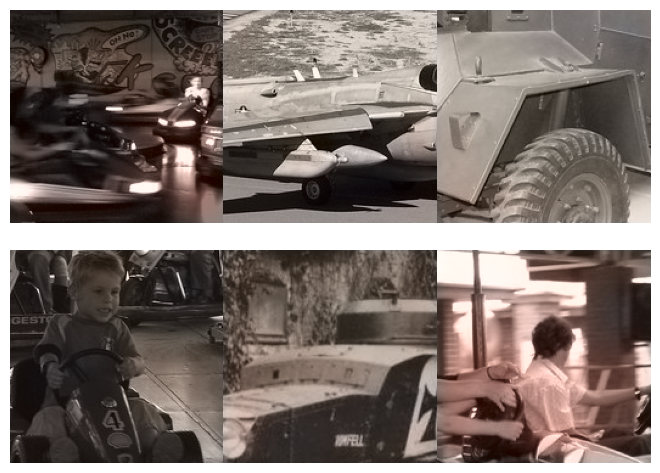

In [14]:
images = next(iter(train_full))
show(images[:6])
show(m.predict(images[:6]))